# Определение подозрительных ПРТО

В данной работе над тестовыми данными проводятся модельные вычисления для определения количества и списка ПРТО, имеющих с высокой долей вероятности неверные координаты. Расчёт таковых вероятностей выходит за рамки рассмотрения данной работы. Предпологается, что приведённые тут алгоритмы помогут определить ПРТО, имеющие с высокой долей вероятности неверные координаты и для реальных данных.

## Данные

Подключим необходимые библиотеки и загрузим тестовые данные.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

from geopy.geocoders import Nominatim       # библиотека, определяющая координаты по адресу
from geopy.distance import geodesic         # библиотека, для расчёта дистанции
geolocator = Nominatim(user_agent="Tester") # Указываем название приложения (так нужно, да)

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

prto = pd.read_excel('test ПРТО.xlsx')

Saving test ПРТО.xlsx to test ПРТО.xlsx
User uploaded file "test ПРТО.xlsx" with length 41112 bytes


В качестве тестовых данные будем использовать специально подготовленный файл с данными по ряду тестовых ПРТО.

In [2]:
prto.head(20)

,prto,lat,lon,add
0,ПРТО-023758,12.345678,98.765432,"117534, Город Москва, Шоссе Варшавское Дом 150"
1,ПРТО-001143,55.737125,37.504821,"Город Москва, Улица Василисы Кожиной Дом 1"
2,ПРТО-050147,55.000000,37.000000,prto
3,ПРТО-007420,55.663456,37.519216,"г. Москва, ул. Новаторов, д. 40, корп. 16."
4,ПРТО-019596,55.663259,37.518986,"г. Москва, ул. Новаторов, д. 40, к. 16"
5,NaN,NaN,NaN,NaN
6,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13..."
7,ПРТО-001104,11.111111,11.111111,"Город Москва, Город Зеленоград Корпус 1212"
8,ПРТО-000134,55.638257,37.677598,"г. Москва, ЮАО, Кантемировская улица, дом 6, к..."
9,NaN,55.000000,36.000000,NaN


Оказалось, что некоторые значения в исходных данных пропущены. Тем не мение, продолжим работу с полным набором имеющихся данных.

In [3]:
prto.count()

prto    762
lat     782
lon     782
add     792
dtype: int64

## Анализ

### Расчёт

"Подозрительными" ПРТО назовём те, которые потенциально могут находится не на своих местах. В оригинальных тестовых данных нам доступны координаты ПРТО через широту и долготу и юридический адрес, по которому такую ПРТО можно обнаружить.

Используя `geopy` можно определить юридический адрес координат ПРТО и соотнтести его с имеющимся. Поскольку доступные адреса ПРТО не имеют одинакового формата, проверку с получаемым адресом проведём по наличию в оригинальном адресе названия улицы и/или названия местности, полученное в адресе из `geopy`. Случаи несовподения адресов будут нами отмечены.

В `geopy` объект, обладающий адресом также обладает границами и мы можем проверить, входят ли оригинальные координаты ПРТО в грацины этого объекта. Случаи невхождения будут нами отмечены.

Кроме того, мы также можем получить координаты центра такого юридического адреса и вычислить расстояние в метрах от него до доступных нам изначально координат ПРТО. Будем фиксировать такие расстояния.




In [4]:
a = []; b = []; c = []; d = []
i = 0
start_time = time.time() # засекаем время
while i < len(prto):
  print(':' + str(i))
  try:
    cc = geolocator.reverse([prto.loc[i, 'lat'], prto.loc[i, 'lon']])

    # получение новых координат и расчёт расстояния
    l1 = prto.loc[i, 'lat'], prto.loc[i, 'lon']
    l2 = cc.latitude, cc.longitude
    cl = geodesic(l1, l2).meters

    # проверка вхожести старых координат в рамки
    if (float(prto.loc[i, 'lat'] >= float(cc.raw['boundingbox'][0]))) \
      and (float(prto.loc[i, 'lat'] <= float(cc.raw['boundingbox'][1]))) \
      and (float(prto.loc[i, 'lon'] >= float(cc.raw['boundingbox'][2]))) \
      and (float(prto.loc[i, 'lon'] <= float(cc.raw['boundingbox'][3]))):
      cb = 0
    else:
      cb = 1

    # проверка полученного адреса с текущим
    r = str(cc.raw['address'].get('road'))
    if r != 'None': # проверяем улицу на наличие
      rr = ['дорога', 'улица', 'проспект', 'шоссе', 'проезд', 'переулок', 'тупик', 'линяя', 'тракт', 'просека', 'аллея', 'магистраль', 'cпуск', 'съезд', 'взвоз', 'бульвар', 'набережная']
      for rname in rr: # оставляем только наименование улиц
        if rname in r:
          if str(r[0]) == str(rname[0]):
            r = str(cc.raw['address'].get('road').strip(str(rname) + ' '))
          else:
            r = str(cc.raw['address'].get('road').strip(' ' + str(rname)))
    else:
      r = ' '
    if (str(cc.raw['address'].get('state')) in str(prto.loc[i, 'add'])) \
      and (r in str(prto.loc[i, 'add'])):
      cd = 0
    else:
      cd = 1
#    time.sleep(1) # поставить на секунду в боевом режиме ?
#    print(prto.loc[i, 'lat'], prto.loc[i, 'lon'])
#    print(cc.latitude, cc.longitude)
  except:
    cc = '--'
    cl = -1
    cb = -1
    cd = -1
  a.append(str(cc))
  b.append(cl)
  c.append(cb)
  d.append(cd)
  i = i + 1
tt = time.time() - start_time
print("Время: %s c" % tt)
prto['n_add'] = a
prto['r'] = b
prto['inbox'] = c
prto['c_add'] = d
сс = prto['r'].count()
del a, b, c, d

:0
:1
:2
:3
:4
:5
:6
:7
:8
:9
:10
:11
:12
:13
:14
:15
:16
:17
:18
:19
:20
:21
:22
:23
:24
:25
:26
:27
:28
:29
:30
:31
:32
:33
:34
:35
:36
:37
:38
:39
:40
:41
:42
:43
:44
:45
:46
:47
:48
:49
:50
:51
:52
:53
:54
:55
:56
:57
:58
:59
:60
:61
:62
:63
:64
:65
:66
:67
:68
:69
:70
:71
:72
:73
:74
:75
:76
:77
:78
:79
:80
:81
:82
:83


:84
:85
:86


:87
:88
:89
:90
:91
:92
:93
:94
:95
:96
:97
:98
:99
:100
:101
:102
:103
:104
:105
:106
:107
:108
:109
:110
:111
:112
:113
:114
:115
:116
:117
:118
:119
:120
:121
:122
:123
:124
:125
:126
:127
:128
:129
:130
:131
:132
:133
:134
:135
:136
:137
:138
:139
:140
:141
:142
:143
:144
:145
:146
:147
:148
:149
:150
:151
:152
:153
:154
:155
:156
:157
:158
:159
:160
:161
:162
:163
:164
:165
:166
:167
:168
:169
:170
:171
:172
:173
:174
:175
:176
:177
:178
:179
:180
:181
:182
:183
:184
:185
:186
:187
:188
:189
:190
:191
:192
:193
:194
:195
:196
:197
:198
:199
:200
:201
:202
:203
:204
:205
:206
:207
:208
:209
:210
:211
:212
:213
:214
:215
:216
:217
:218
:219
:220
:221
:222
:223
:224
:225
:226
:227
:228
:229
:230
:231
:232
:233
:234
:235
:236
:237
:238
:239
:240
:241
:242
:243
:244
:245
:246
:247
:248
:249
:250
:251
:252
:253
:254
:255
:256
:257
:258
:259
:260
:261
:262
:263


:264
:265
:266
:267
:268
:269
:270
:271
:272
:273
:274
:275
:276
:277
:278
:279
:280
:281
:282
:283
:284
:285
:286
:287
:288
:289
:290
:291
:292
:293
:294
:295
:296
:297
:298
:299
:300
:301
:302
:303
:304
:305
:306
:307
:308
:309
:310
:311
:312
:313
:314
:315
:316
:317
:318
:319
:320
:321
:322
:323
:324
:325
:326
:327
:328
:329
:330
:331
:332
:333
:334
:335
:336
:337
:338
:339
:340
:341
:342
:343
:344
:345
:346
:347
:348
:349
:350
:351
:352
:353
:354
:355
:356
:357
:358
:359
:360
:361
:362
:363
:364
:365
:366
:367
:368
:369
:370
:371
:372
:373
:374
:375
:376
:377
:378
:379
:380
:381
:382
:383
:384
:385
:386
:387
:388
:389
:390
:391
:392
:393
:394
:395
:396
:397
:398
:399
:400
:401
:402
:403
:404
:405
:406
:407
:408
:409
:410
:411
:412
:413
:414
:415
:416
:417
:418
:419
:420
:421
:422
:423
:424
:425
:426
:427
:428
:429
:430
:431
:432
:433
:434
:435
:436
:437
:438
:439
:440
:441
:442
:443
:444
:445
:446
:447
:448
:449
:450
:451
:452
:453
:454
:455
:456
:457
:458
:459
:460
:461
:462
:463


:474
:475
:476
:477
:478
:479
:480
:481
:482
:483
:484
:485
:486
:487
:488
:489
:490
:491
:492
:493
:494
:495
:496
:497
:498
:499
:500
:501
:502
:503
:504
:505
:506
:507
:508
:509
:510
:511
:512
:513


:514
:515
:516
:517
:518
:519
:520
:521
:522
:523
:524
:525
:526
:527
:528
:529
:530
:531
:532
:533
:534
:535
:536
:537
:538
:539
:540
:541
:542
:543
:544
:545
:546
:547
:548
:549
:550
:551
:552
:553
:554
:555
:556
:557
:558
:559
:560
:561
:562
:563
:564
:565
:566
:567
:568
:569
:570
:571
:572
:573


:574
:575
:576
:577
:578
:579
:580
:581
:582
:583
:584
:585
:586
:587
:588
:589
:590
:591
:592
:593
:594
:595
:596
:597
:598
:599
:600
:601
:602
:603
:604
:605
:606
:607
:608
:609
:610
:611
:612
:613
:614
:615
:616
:617
:618
:619
:620
:621
:622
:623
:624
:625
:626
:627
:628
:629
:630
:631
:632
:633
:634
:635
:636
:637
:638
:639
:640
:641
:642
:643
:644
:645
:646
:647
:648
:649
:650
:651
:652
:653
:654
:655
:656
:657
:658
:659
:660
:661
:662
:663
:664
:665
:666
:667
:668
:669
:670
:671
:672
:673
:674
:675
:676
:677
:678
:679
:680
:681
:682
:683
:684
:685
:686
:687
:688
:689
:690
:691
:692
:693
:694
:695
:696
:697
:698
:699
:700
:701
:702
:703
:704
:705
:706
:707
:708
:709
:710
:711
:712
:713
:714
:715
:716
:717
:718
:719
:720
:721
:722
:723
:724
:725
:726
:727
:728
:729
:730
:731
:732
:733
:734
:735
:736
:737
:738
:739
:740
:741
:742
:743
:744
:745
:746
:747
:748
:749
:750
:751
:752


:753
:754
:755
:756
:757
:758
:759
:760
:761
:762
:763
:764
:765
:766
:767
:768
:769
:770
:771
:772
:773
:774
:775
:776
:777
:778
:779
:780
:781
:782
:783
:784
:785
:786
:787
:788
:789
:790
:791
:792
:793
:794
:795
:796
:797
:798
:799
Время: 397.86066579818726 c


Убираем ПРТО для которых не получилось получить юридический адрес из координат, такие случае выпадают из нашего анализа.

Получаем таблицу в которой помимо предыдущих данных добавлены ещё четыре колонки:

*   `n_add` -- адрес, полученный по изначальным координатам
*   `r` -- расстояние между координатами центра адреса и изначальных коориданат ПРТО
*   `inbox` -- факт невхождения оригинальных координат в границы адреса (1 -невхождение; 0 - вхождение)
*   `c_add` -- факт несовпадений адресов (1 - несовпадение; 0 - совпадение)

Таким образом получаем три критерия для оценки "Подозрительности" ПРТО, хотя стоит отметить, что `inbox` и `c_add` очевидно не обладают линейной независимостью. Также имеется `n_add` для лишней визуальной проверки.

In [5]:
prto = prto[prto['n_add'] != '--'].reset_index(drop=True)

prto.head(10)

,prto,lat,lon,add,n_add,r,inbox,c_add
0,ПРТО-023758,12.345678,98.765432,"117534, Город Москва, Шоссе Варшавское Дом 150","မင်းသန်း Min Than, မြိတ်မြို့, မြိတ်ခရိုင်, တန...",271.761935,1,1
1,ПРТО-001143,55.737125,37.504821,"Город Москва, Улица Василисы Кожиной Дом 1","Деловой центр ""Парк Победы"", 1, улица Василисы...",38.860714,0,0
2,ПРТО-050147,55.000000,37.000000,prto,"Буриново, сельское поселение Деревня Тростье, ...",133.381452,0,1
3,ПРТО-007420,55.663456,37.519216,"г. Москва, ул. Новаторов, д. 40, корп. 16.","40 к16, улица Новаторов, Обручевский район, Мо...",10.664232,0,0
4,ПРТО-019596,55.663259,37.518986,"г. Москва, ул. Новаторов, д. 40, к. 16","40 к16, улица Новаторов, Обручевский район, Мо...",35.216165,0,0
5,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1
6,ПРТО-001104,11.111111,11.111111,"Город Москва, Город Зеленоград Корпус 1212","Nafada, Gombe, Nigeria",17100.835470,0,1
7,ПРТО-000134,55.638257,37.677598,"г. Москва, ЮАО, Кантемировская улица, дом 6, к...","6 к2, Кантемировская улица, район Москворечье-...",1.890131,0,0
8,NaN,55.000000,36.000000,NaN,"сельское поселение Село Адуево, Медынский райо...",2406.361628,0,1
9,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1


Те ПРТО, координаты которых находятся за пределами границ, связанного с ними адреса вызывают подозрение в первую очередь, поскольку это означает, что указанные объекты либо находятся в "поле", где указать конкретный юридический ориентир затруднительно и потому `geopy` выдал адрес ближайшего объекта к которому можно привязать данные координаты, либо имеется явное несовпадение между исходными координатами ПРТО и её юридическим адресом.

Укажем их количество ниже:

In [6]:
print('Количество: ', prto.loc[prto['inbox'] == 1, 'r'].count())

prto[prto['inbox'] == 1]

Количество:  214


,prto,lat,lon,add,n_add,r,inbox,c_add
0,ПРТО-023758,12.345678,98.765432,"117534, Город Москва, Шоссе Варшавское Дом 150","မင်းသန်း Min Than, မြိတ်မြို့, မြိတ်ခရိုင်, တန...",271.761935,1,1
10,ПРТО-023805,55.737628,37.514578,"г. Москва, ул. Тучковская, опора в районе д. 11","13, улица Неверовского, район Дорогомилово, Мо...",36.627568,1,1
12,ПРТО-023806,55.869633,37.720401,"г. Москва, ул. Коломенская, опора в районе д. ...","Поляна сказок, улица Проходчиков, Ярославский ...",215.358806,1,1
19,ПРТО-023807,55.869870,37.720002,"г. Москва, ул. Коломенская, опора в районе д. ...","Поляна сказок, улица Проходчиков, Ярославский ...",233.199674,1,1
22,ПРТО-001086,55.792220,37.635570,"г. Москва, ЗАО, Солнцевский проспект, дом 13 к...","Третье транспортное кольцо, Мещанский район, М...",32.050572,1,1
...,...,...,...,...,...,...,...,...
757,ПРТО-023817,55.604579,37.165393,"г. Москва, пос. Кокошкино, ул. Дзержинского, д...","вл14, улица Дзержинского, Кокошкино, поселение...",11.203740,1,0
760,ПРТО-17295,37.777777,55.555555,"119192, Город Москва, Проспект Мичуринский Дом 42","قره آغاچ, دهستان زاوکوه, بخش پیشکمر, شهرستان ک...",3341.162952,1,1
764,ПРТО-17299,37.777777,55.555555,"119192, Город Москва, Проспект Мичуринский Дом 42","قره آغاچ, دهستان زاوکوه, بخش پیشکمر, شهرستان ک...",3341.162952,1,1
765,ПРТО-17302,37.777777,55.555555,"119192, Город Москва, Проспект Мичуринский Дом 42","قره آغاچ, دهستان زاوکوه, بخش پیشکمر, شهرستان ک...",3341.162952,1,1


Имеющие несовпадение по адресу ПРТО также представляют интерес с точки зрения уточнения их местоположения ПРТО, но в меньшей степени, чем предыдущий критерий, поскольку при условии плотной городской застройки возможно некорректное определение адреса по координатам.

Укажкм количество таких ПРТО ниже:

In [7]:
print('Количество: ', prto.loc[prto['c_add'] == 1, 'r'].count())

prto[prto['c_add'] == 1].head(10)

Количество:  386


,prto,lat,lon,add,n_add,r,inbox,c_add
0,ПРТО-023758,12.345678,98.765432,"117534, Город Москва, Шоссе Варшавское Дом 150","မင်းသန်း Min Than, မြိတ်မြို့, မြိတ်ခရိုင်, တန...",271.761935,1,1
2,ПРТО-050147,55.000000,37.000000,prto,"Буриново, сельское поселение Деревня Тростье, ...",133.381452,0,1
5,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1
6,ПРТО-001104,11.111111,11.111111,"Город Москва, Город Зеленоград Корпус 1212","Nafada, Gombe, Nigeria",17100.835470,0,1
8,NaN,55.000000,36.000000,NaN,"сельское поселение Село Адуево, Медынский райо...",2406.361628,0,1
9,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1
10,ПРТО-023805,55.737628,37.514578,"г. Москва, ул. Тучковская, опора в районе д. 11","13, улица Неверовского, район Дорогомилово, Мо...",36.627568,1,1
11,NaN,44.444444,44.444444,"Город Москва, Поселение Новофедоровское, Кварт...","Степновский муниципальный округ, Ставропольски...",23511.925841,0,1
12,ПРТО-023806,55.869633,37.720401,"г. Москва, ул. Коломенская, опора в районе д. ...","Поляна сказок, улица Проходчиков, Ярославский ...",215.358806,1,1
13,ПРТО-017857,55.600977,37.145781,"г. Москва, пос. Кокошкино, х. Брехово, крестья...","Объездная улица, СНТ «Искан», Брёхово, поселен...",0.855483,0,1


### Фильтр

Для определения списка "подозрительных" ПРТО возьмём те объекты у которых имеется несовпадение по юридическому адресу и при этом рассояние от указанных координат до центра найденного юридического адреса больше некого параметра (в качестве примера возьмём медианное значение данной группы, также можно использовать другие квантили (`.describe()`)) или непопадающие в границы объекта, найденного для известных координат.

Указанный фильтр не является исчерпывающим и конечным и может быть изменён исходя из колличества полученных им "подозрительных" ПРТО, полученном из реальных данных, из ресурсов, возможных для выделения на установления факта статуса местоположения ПРТО и из поставленных в дальнейшем задач.

Можно получить распределение по расстоянию между известными координатами и координатами

Параметр: 60.315644893085604


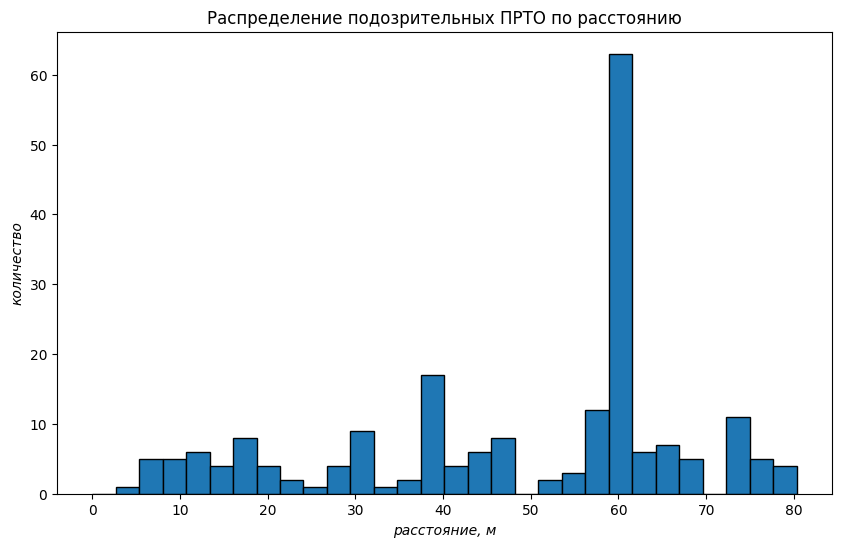

In [10]:
pp = prto.loc[(prto['c_add'] == 1), 'r'].median() # медиана в качестве параметра

print('Параметр:', pp)

prto.loc[((prto['c_add'] == 1) & (pp <= prto['r'])) | (prto['inbox'] == 1), 'r'].hist(
    bins=30,
    grid=False,
    figsize=(10, 6),
    edgecolor='black',
    range=[0, pp + 20]
);
plt.title('Распределение подозрительных ПРТО по расстоянию');
plt.xlabel('расстояние, м', style='italic');
plt.ylabel('количество', style='italic');

Как можно заметить приведенное распределение "подозрительных" ПРТО действительно выглядит подозрительно, поскольку, исключая очевидно большое количество одинаковых тестовых координат, имеющих фиксированное расстояние до центра соответсвующего им блока ~60.315645 м, оно выглядит равномерно.

Кроме того можно вывести список таких ПРТО:

In [11]:
prto.loc[((prto['c_add'] == 1) & (pp <= prto['r'])) | (prto['inbox'] == 1)]

,prto,lat,lon,add,n_add,r,inbox,c_add
0,ПРТО-023758,12.345678,98.765432,"117534, Город Москва, Шоссе Варшавское Дом 150","မင်းသန်း Min Than, မြိတ်မြို့, မြိတ်ခရိုင်, တန...",271.761935,1,1
2,ПРТО-050147,55.000000,37.000000,prto,"Буриново, сельское поселение Деревня Тростье, ...",133.381452,0,1
5,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1
6,ПРТО-001104,11.111111,11.111111,"Город Москва, Город Зеленоград Корпус 1212","Nafada, Gombe, Nigeria",17100.835470,0,1
8,NaN,55.000000,36.000000,NaN,"сельское поселение Село Адуево, Медынский райо...",2406.361628,0,1
...,...,...,...,...,...,...,...,...
774,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1
775,ПРТО-050482,55.636070,37.742514,"Москва, Баженоа, 1","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1
776,NaN,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1
777,ПРТО-050489,55.636070,37.742514,": г. Москва, ЗАО, Солнцевский проспект, дом 13...","12 к1, улица Борисовские Пруды, Борисово, Брат...",60.315645,0,1


В качестве сравнения можно проделать ту же операцию со списком "неподозрительных" ПРТО.

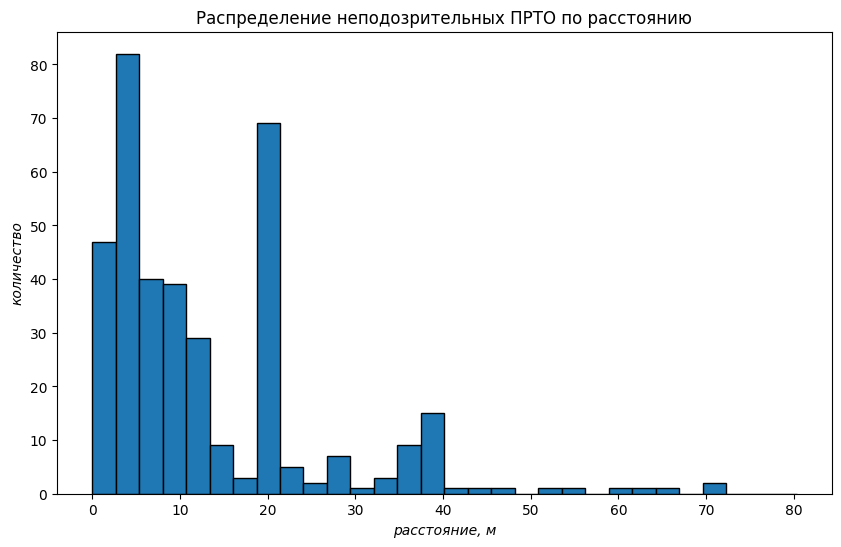

In [12]:
prto.loc[(((prto['c_add'] == 1) & (pp <= prto['r'])) | (prto['inbox'] == 1)) != True, 'r'].hist(
    bins=30,
    grid=False,
    figsize=(10, 6),
    edgecolor='black',
    range=[0, pp + 20]
);
plt.title('Распределение неподозрительных ПРТО по расстоянию');
plt.xlabel('расстояние, м', style='italic');
plt.ylabel('количество', style='italic');

За исключением некоторых пиков и провалов, вызванных "тестовостью" изучаемых данных указанное распределение имеет Пуассоновский вид, что позволяет говорить о высокой вероятности их достоверности.

Также можно привести список "неподозрительных" ПРТО:

In [13]:
prto.loc[(((prto['c_add'] == 1) & (pp <= prto['r'])) | (prto['inbox'] == 1)) != True]

,prto,lat,lon,add,n_add,r,inbox,c_add
1,ПРТО-001143,55.737125,37.504821,"Город Москва, Улица Василисы Кожиной Дом 1","Деловой центр ""Парк Победы"", 1, улица Василисы...",38.860714,0,0
3,ПРТО-007420,55.663456,37.519216,"г. Москва, ул. Новаторов, д. 40, корп. 16.","40 к16, улица Новаторов, Обручевский район, Мо...",10.664232,0,0
4,ПРТО-019596,55.663259,37.518986,"г. Москва, ул. Новаторов, д. 40, к. 16","40 к16, улица Новаторов, Обручевский район, Мо...",35.216165,0,0
7,ПРТО-000134,55.638257,37.677598,"г. Москва, ЮАО, Кантемировская улица, дом 6, к...","6 к2, Кантемировская улица, район Москворечье-...",1.890131,0,0
13,ПРТО-017857,55.600977,37.145781,"г. Москва, пос. Кокошкино, х. Брехово, крестья...","Объездная улица, СНТ «Искан», Брёхово, поселен...",0.855483,0,1
...,...,...,...,...,...,...,...,...
756,ПРТО-17293,55.678070,37.482224,"119454, Город Москва, Улица Лобачевского Дом 19","19, улица Лобачевского, Проспект Вернадского, ...",6.255014,0,0
758,ПРТО-023818,55.587778,37.488333,"г. Москва, пос. Сосенское, п. Газопровод","поселение Сосенское, Москва, Центральный федер...",0.757150,0,0
759,ПРТО-17309,55.685730,37.572346,"117292, Город Москва, Улица Профсоюзная Дом 3","3, Профсоюзная улица, Академический район, Мос...",9.115337,0,0
769,ПРТО-005210,55.725630,37.527480,"г. Москва, ЗАО, ул. Пудовкина, опора в районе ...","13, улица Пудовкина, Потылиха, район Раменки, ...",3.609962,0,0


## Вывод

В данной работе были приведены некоторые алгоритмы и рекомендации по анализу массива ПРТО с точки зрения корректности их местоположения. Данные методы не помогут получить полный и исчерпывающий список ПРТО, имеющих неверные координаты, но помогут определить наиболее явные несовпадения, а также дать некоторую классификацию данных с указанной точки зрения.

При этом подобный расчёт всего массива реальных данных займёт примерно следующее время:

In [14]:
cad = 20735 # количество всех ПРТО в реальных данных

print(str(round(сс / tt * cad / 60 / 60, 2)) + ' ч')

11.58 ч
